

#**DEEP LEARNING PROJECT**

Students

*   Jacopo Dona' - Mat. 229369
*   Edoardo Barba - Mat. 231592



## **Introduction**

The goal of this project is to build, train and evaluate a deep learning framework on a setting of Unsupervised Domain Adaptation. 
The base task consists of an object recognition challenge and in order to perform UDA we are supposed to:

1.   Train the model supervisedly on the source domain
2.   Train the model unsupervisedly on the training set of the target domain
3.   Evaluate the model on the test set of the target domain


##**Dataset**

As a UDA benchmark, in this assigment we will use the Adaptiode object recognition dataset. We use 20 randomly chosen categories from the *product* and *real world* domains. 
We will perform domain adaptation in both directions i.e. from product domain to real world domain and from real world domain to product domain. In order to split the dataset we use a standard 80%/20% split.


## **Our solution**

***ADDA - Adversarial Discriminative Domain Adaptation***

We decided to follow the idea described in this paper:
[Adversarial Discriminative Domain Adaptation](https://arxiv.org/abs/1702.05464)

This approach combines discriminative modeling, untied weight sharing, and a GAN loss. 
Our model first learns a discriminative representation using the labels in the source domain and then a separate encoding that maps the target data to the same space using an asymmetric mapping learned through a domain-adversarial loss. 

Consider our model divided in feature extractor and classifier. As feature extractor we decided to use ResNet-18 and as classifier a one layer fully connected structure. Our goal is to learn a feature extractor and classifier able to correctly classify target images but to train it we cannot use target labels, we can only exploit source ones. The main idea is to first train a model (feature extractor and classificator) to correctly classify source images. At this point we have a couple source representation $M_s$ and classifier $C_s$ that can correctly classify source images. The next step is to learn a different representation $M_t$ useful to discriminate target images; we learn it  through an adversarial setting. Finally we use the same classifier $C_s$ learned at the beginning with the new target representation Mt to classify target images.

The pipeline can be divided in 3 steps:

1.   ***Pre-training***:
We first pre-train a source encoder CNN using labeled source image examples. 

2.   ***Adversarial Adaptation***:
Next, we perform adversarial adaptation by learning a target
encoder CNN such that a discriminator that sees encoded source and target examples cannot reliably predict their domain
label.

3.   ***Testing***:
During testing, target images are mapped with the target encoder to the shared feature space and classified by the source classifier


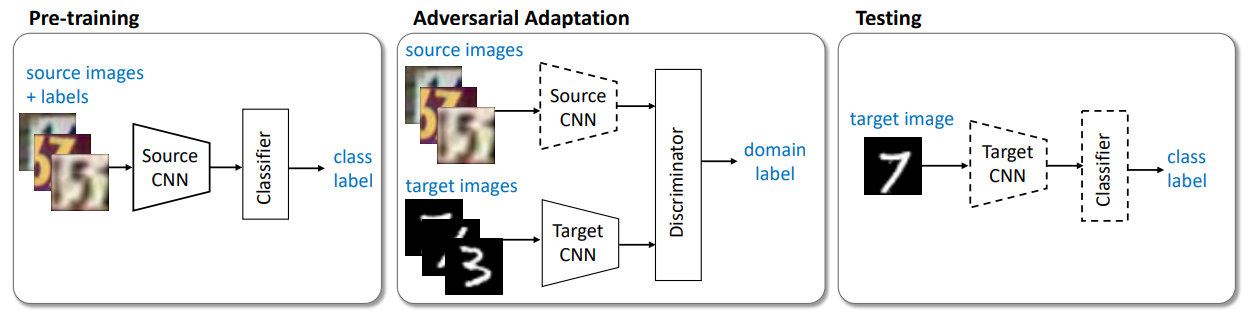

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from tqdm import trange
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
device = 'cuda:0'

# 0) Import Dataset on Drive


Prerequisites:

*   Add https://drive.google.com/file/d/1FmdsvetC0oVyrFJ9ER7fcN-cXPOWx2gq/view to your drive
*   Move Adaptiope.zip inside a folder called datasets

You can skip this part once it has been run the first time

In [ ]:
from os import makedirs
import os
import shutil
from tqdm import tqdm
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!mkdir dataset
!cp "/content/gdrive/MyDrive/datasets/Adaptiope.zip" "dataset/"
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png 

In [ ]:
!rm -rf adaptiope_small

In [ ]:
!mkdir adaptiope_small
classes = os.listdir("Adaptiope/product_images")
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
          "purse", "stand mixer", "stroller"]
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  makedirs(td)
  for c in tqdm(classes):
    c_path = os.path.join(d, c)
    c_target = os.path.join(td, c)
    shutil.copytree(c_path, c_target)

100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


In [ ]:
!cp -a "/content/adaptiope_small/." "/content/gdrive/MyDrive/datasets/adaptiope_small"

You should now have a new folder called adaptiode_small in your drive with the new smaller dataset to use

# 1) Load Dataset


Dataset is loaded by using a dataloader. Images are resized at 224x224 pixels. We initially used a cropping operation on the images but noticed better performances by removing the crop. Batches are of size 16.

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
BATCH_SIZE=16
IMAGE_SIZE=224
#CROP_SIZE=224


def get_data(split=True):
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((IMAGE_SIZE, IMAGE_SIZE)))                  # resize image to 224x224
  transform.append(T.ToTensor())                                            # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))    # normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                                          # compose the above transformations into one

  real_domain=torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/datasets/adaptiope_small/real_life",transform=transform)
  product_domain=torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/datasets/adaptiope_small/product_images",transform=transform)

  if(split):
    #Split into 80%-20% sets
    #Split is random split, changes through iterations
    num_samples = len(real_domain)
    training_samples = int(num_samples * 0.8)
    test_samples = num_samples - training_samples

    product_training, product_test = torch.utils.data.random_split(product_domain, [training_samples, test_samples])
    real_training, real_test = torch.utils.data.random_split(real_domain, [training_samples, test_samples])

    real_train_loader = torch.utils.data.DataLoader(real_training, BATCH_SIZE, shuffle=True)
    real_test_loader = torch.utils.data.DataLoader(real_test, BATCH_SIZE, shuffle=True)

    product_train_loader = torch.utils.data.DataLoader(product_training, BATCH_SIZE, shuffle=True)
    product_test_loader = torch.utils.data.DataLoader(product_test, BATCH_SIZE, shuffle=True)

    return real_train_loader, real_test_loader, product_train_loader, product_test_loader
  
  real_loader = torch.utils.data.DataLoader(real_domain, BATCH_SIZE, shuffle=True)
  product_loader = torch.utils.data.DataLoader(product_domain, BATCH_SIZE, shuffle=True)

  return real_loader, product_loader

In [ ]:
real_train_loader, real_test_loader, product_train_loader, product_test_loader = get_data()

#2)Networks definition

Definition of method to initialize ResNet18 and classifier class

##ResNet18

We use ResNet18 as feature extractor, we replace the classification layer with an identity layer.

In [ ]:
def initialize_resnet18():

  # load the pre-trained ResNet
  resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
  
  # re-initalize the output layer
  resnet.fc = nn.Identity()
  return resnet

##Classifier

We use a feed forward classifier with 512 features (produced by Resnet) in input and 20 output (number of classes) with dropout

In [ ]:
class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(512, 20)
        #self.bns = nn.BatchNorm1d(20, affine=False)

    def forward(self, feat):
        out = F.dropout(F.relu(feat), training=self.training)
        out = self.fc(out)
        #prova batch norm
        #out = self.bns(out)
        return out

## Define Discriminator Architecture

We use a feed forward architecture as discriminator in the adversarial training. It has 3 layers, going from 512 features of Resnet to a binary output for guessing the domain of the sample.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
        nn.Linear(512, 50),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(50, 20),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(20, 1)
        )

    def forward(self, x):
      out = self.main(x)
      return out

#3) Training Methods

## Upper and Lower Bound

**For lower bound**: source-only baseline that should be taken into account when evaluating any UDA framework simply consists of the score obtained when training your model on the source domain and evaluating it on the target domain, without any domain alignment strategy involved


**For upper bound**: The upper bound consists in the value of your evaluation metric (in this case the validation accuracy) that is obtained by enabling supervision on the target domain.


In [ ]:
def main_upperbound(target_train_loader, target_test_loader, lr = 0.001, wd = 0.0001, momentum = 0.9, early_stopping=3,PRW=True):

  if(PRW):
    filepath_fe='/content/gdrive/MyDrive/trained_models/no_crop/prw_up_bound_extractor.pt'
    filepath_cf='/content/gdrive/MyDrive/trained_models/no_crop/prw_up_bound_classifier.pt'
  else:
    filepath_fe='/content/gdrive/MyDrive/trained_models/no_crop/rwp_up_bound_extractor.pt'
    filepath_cf='/content/gdrive/MyDrive/trained_models/no_crop/rwp_up_bound_classifier.pt'
  
  num_epochs = 10
  feature_extr = initialize_resnet18()
  classifier = Classifier()
  feature_extr.to(device)
  classifier.to(device)
  
  optim = get_optimizer(feature_extr, classifier, lr, wd, momentum)

  criterion = torch.nn.CrossEntropyLoss()
  best_val_accuracy = 0
  patience = 0
  for epoch in range(1, num_epochs+1):
    feature_extr.train()
    classifier.train()
    train_loss, train_accuracy,_,_,_ = do_epoch(feature_extractor = feature_extr, classifier = classifier, criterion = criterion, dataloader = target_train_loader, optim = optim)
    
    feature_extr.eval()
    classifier.eval()
    with torch.no_grad():
        val_loss, val_accuracy, pred, true, _ = do_epoch(feature_extractor = feature_extr, classifier = classifier, criterion = criterion, dataloader = target_test_loader, optim=None)

    tqdm.write(f'EPOCH {epoch:03d}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f} '
                   f'val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}')
    
            
    #Early Stopping Criterion
    if(val_accuracy>best_val_accuracy):
      #first save the model
      best_val_accuracy = val_accuracy

      patience=0
      best_epoch=epoch
      best_train_loss=train_loss
      best_train_accuracy=train_accuracy
      best_val_loss=val_loss
      best_feature_extr=feature_extr
      best_classifier = classifier 
    else:
      patience+=1
      
    if(patience==early_stopping):
      print("EARLY STOPPING: stopped training after ",patience," epochs without improvements")
      feature_extr = best_feature_extr
      classifier = best_classifier
      tqdm.write(f'BEST_ EPOCH {best_epoch:03d}: train_loss={best_train_loss:.4f}, train_accuracy={best_train_accuracy:.4f} '
                  f'val_loss={best_val_loss:.4f}, val_accuracy={best_val_accuracy:.4f}')
      print('Saving model...')
      torch.save(feature_extr.state_dict(), filepath_fe)
      torch.save(classifier.state_dict(), filepath_cf)
      break
    print('Saving model...')
    torch.save(feature_extr.state_dict(), filepath_fe)
    torch.save(classifier.state_dict(), filepath_cf)

  return pred, true

In [ ]:
def main_lowerbound(source_train_loader, target_test_loader, lr = 0.001, wd = 0.000001, momentum = 0.9, early_stopping=2,PRW=True):
  
  if(PRW):
    filepath_fe='/content/gdrive/MyDrive/trained_models/no_crop/prw_low_bound_extractor.pt'
    filepath_cf='/content/gdrive/MyDrive/trained_models/no_crop/prw_low_bound_classifier.pt'
  else:
    filepath_fe='/content/gdrive/MyDrive/trained_models/no_crop/rwp_low_bound_extractor.pt'
    filepath_cf='/content/gdrive/MyDrive/trained_models/no_crop/rwp_low_bound_classifier.pt'

  patience=0
  num_epochs = 10
  feature_extr = initialize_resnet18()
  classifier = Classifier()
  
  feature_extr.to(device)
  classifier.to(device)

  optim = get_optimizer(feature_extr, classifier, lr, wd, momentum)
  criterion = torch.nn.CrossEntropyLoss()

  best_val_accuracy = 0
  for epoch in range(1, num_epochs+1):
    feature_extr.train()
    classifier.train()
    train_loss, train_accuracy, _,_,_ = do_epoch(feature_extractor = feature_extr, classifier = classifier, criterion = criterion, dataloader = source_train_loader, optim = optim)
    
    feature_extr.eval()
    classifier.eval()
    with torch.no_grad():
        val_loss, val_accuracy, pred, true, _ = do_epoch(feature_extractor = feature_extr, classifier = classifier, criterion = criterion, dataloader = target_test_loader, optim=None)

    tqdm.write(f'EPOCH {epoch:03d}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f} '
                   f'val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}')
    

    
    #Early Stopping Criterion
    if(val_accuracy>best_val_accuracy):
      patience=0
      best_epoch=epoch
      best_val_accuracy=val_accuracy
      best_train_loss=train_loss
      best_train_accuracy=train_accuracy
      best_val_loss=val_loss
      best_feature_extr=feature_extr
      best_classifier = classifier 
    else:
      patience+=1
    if(patience==early_stopping):
      print("EARLY STOPPING: stopped training after ",patience," epochs without improvements")
      feature_extr = best_feature_extr
      classifier = best_classifier
      tqdm.write(f'BEST_ EPOCH {best_epoch:03d}: train_loss={best_train_loss:.4f}, train_accuracy={best_train_accuracy:.4f} '
                   f'val_loss={best_val_loss:.4f}, val_accuracy={best_val_accuracy:.4f}')
      print('Saving model...')
      torch.save(feature_extr.state_dict(), filepath_fe)
      torch.save(classifier.state_dict(), filepath_cf)
      break

    print('Saving model...')
    torch.save(feature_extr.state_dict(), filepath_fe)
    torch.save(classifier.state_dict(), filepath_cf)

  return pred, true

## Training methods

In [1]:
def do_epoch(feature_extractor, classifier, criterion, dataloader, optim=None, device = 'cuda:0'):
  total_loss = 0
  total_accuracy = 0
  total_pred = []
  total_true = []

  for x, y_true in tqdm(dataloader, leave = False):
    x = x.to(device)
    y_true = y_true.to(device)
    y_pred = classifier(feature_extractor(x)) #Classifier takes as input features obtained by the Resnet feature extractor

    total_pred = total_pred + y_pred.tolist()
    total_true = total_true + y_true.tolist()

    loss = criterion(y_pred, y_true)
    
    #Add L2 regularization 
    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in classifier.parameters())
 
    loss = loss + l2_lambda * l2_norm

    #if optim is None, we are testing, not training
    if optim is not None:
          optim.zero_grad()
          loss.backward()
          optim.step()

    total_loss += loss.item()
    total_accuracy += (y_pred.max(1)[1] == y_true).float().mean().item() 

  mean_loss = total_loss / len(dataloader)
  mean_accuracy = total_accuracy / len(dataloader)
  
  return mean_loss, mean_accuracy, total_pred, total_true, total_loss

In [ ]:
def loop_iterable(iterable):#Returns samples from dataloader
    while True:
        yield from iterable

def set_requires_grad(model, requires_grad=True):#Set requires_grad of every parameter in the network to True/False. Used to enable training or freezing the network. True= weights updated, False= weights freezed
  for param in model.parameters():
    param.requires_grad = requires_grad

In [ ]:
def get_optimizer(feature_extractor, classifier, lr, wd, momentum):
  
  # we will create two groups of weights, one for the newly initialized layer
  # and the other for rest of the layers of the network
  
  classifier_weights = [] #parameters of the newly defined output layer
  feature_extractor_weights = []
   
  if classifier == None:
    optimizer = torch.optim.Adam([{'params': feature_extractor_weights}])

  else:
    # iterate through the layers of the network
    for param in feature_extractor.parameters(): 
      feature_extractor_weights.append(param)
    
    for param in classifier.parameters(): 
      classifier_weights.append(param)
    #We use different learning rate for classifier and for Resnet finetuning
    optimizer = torch.optim.Adam([ #list of dictionaries
          {'params': feature_extractor_weights},
          {'params': classifier_weights, 'lr': lr} #parameters of the final layer, specify a different lr, 10 times bigger than the rest of the network. 
      ], lr=lr / 10, weight_decay=wd) #learning rate divided by 10
  
  return optimizer

##Pre-training 

In this first step we learn a source representation mapping  $M_s$, along with a source classifier  $C_s$. We use a pretrained version of ResNet18, we fine tune it and train a linear classifier. Only source domain label information is used.

In order to optimize the classification, we use a standard supervised loss:

>   $\begin{equation} \min_{Ms,C} L_{cls}(X_s, Y_t) =
- \mathbb{E}_{(xs,ys)∼(Xs,Yt)}  \sum_{k=1}^K \mathbb{I}_{[k=ys]} log C(M_s(x_s)) \end{equation}$





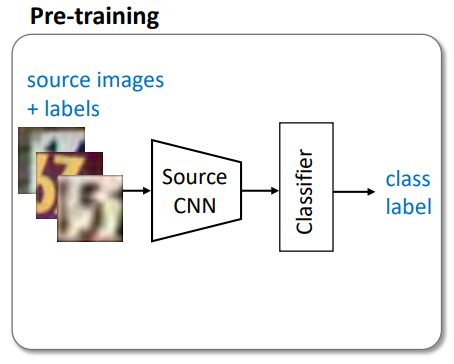

In [ ]:
#PRW = True if the direction of domain adaptation is Product --> Real World
#PRW = False if the direction of domain adaptation is Real World --> Product

def main_pretraining(source_train_loader, source_test_loader, PRW, lr = 0.001, wd = 0.000001, momentum = 0.9, early_stopping=3, save_model = True, log_dir = "runs/exp1"):

  writer = SummaryWriter(log_dir=log_dir)
  
  num_epochs = 10
  feature_extr = initialize_resnet18()

  classifier = Classifier()
  
  feature_extr.to(device)
  classifier.to(device)
  
  optim = get_optimizer(feature_extr, classifier, lr, wd, momentum)
  criterion = torch.nn.CrossEntropyLoss()

  best_val_accuracy = 0
  patience = 0
  for epoch in range(1, num_epochs+1):
    feature_extr.train()
    classifier.train()
    train_loss, train_accuracy,_,_,_ = do_epoch(feature_extractor = feature_extr, classifier = classifier,  criterion = criterion, dataloader = source_train_loader, optim = optim)
    
    feature_extr.eval()
    classifier.eval()
    with torch.no_grad():
        val_loss, val_accuracy,_,_,_ = do_epoch(feature_extractor = feature_extr, classifier = classifier,  criterion = criterion, dataloader = source_test_loader, optim=None)

    # add values to logger
    writer.add_scalar('Loss/train_loss', train_loss, epoch)
    writer.add_scalar('Loss/val_loss', val_loss, epoch)
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val_accuracy', val_accuracy, epoch)

    tqdm.write(f'EPOCH {epoch:03d}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f} '
                   f'val_loss={val_loss:.4f}, val_accuracy={val_accuracy:.4f}')
    
        #Early Stopping Criterion
    if(val_accuracy>best_val_accuracy):
      #first save the model
      best_val_accuracy = val_accuracy
      if save_model:
        
        print('Saving model...')
        if PRW:
          torch.save(feature_extr.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/PRW_source_extractor.pt')
          torch.save(classifier.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/PRW_classifier.pt')
        else:
          torch.save(feature_extr.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/RWP_source_extractor.pt')
          torch.save(classifier.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/RWP_classifier.pt')

      patience=0
      best_epoch=epoch
      best_train_loss=train_loss
      best_train_accuracy=train_accuracy
      best_val_loss=val_loss
      best_feature_extr=feature_extr
      best_classifier = classifier 
    else:
      patience+=1
      
      if(patience==early_stopping):
        print("EARLY STOPPING: stopped training after ",patience," epochs without improvements")
        feature_extr = best_feature_extr
        classifier = best_classifier
        tqdm.write(f'BEST_ EPOCH {best_epoch:03d}: train_loss={best_train_loss:.4f}, train_accuracy={best_train_accuracy:.4f} '
                    f'val_loss={best_val_loss:.4f}, val_accuracy={best_val_accuracy:.4f}')
        break

  # close the logger
  writer.close()

## Adversarial Training

In this step we optimize the target representation $M_t$ throught an adversarial discriminative domain adaptation setting. The goal is to find $M_t$ such that we are able to classify target samples appending the classifier $C_s$ to it. 

In order to do this we use the pretrained source model $M_s$, as an initialization for the target representation space and fix it during adversarial training. In order to use the same classifier that we learned in the pretraining step, we need to optimize $M_t$ such that it is able to learn domain invariant features from the source domain to the target one.  

We use a domain discriminator $D$, which classifies wheter a representation is drawn from the source or target domain. We train the discriminator in order to classify correctly between the 2 domains through a standard supervised loss:


>   $\begin{equation}L_{adv_D} (X_s, X_t, M_s, M_t) = − \mathbb{E}_{x_s∼X_s} [log D(M_s(x_s))] − \mathbb{E}_{x_t∼X_t} [log(1 − D(M_t(x_t)))]\end{equation}$



Then, target mappings is optimized according to a constrained adversarial objective.

We employed the following adversarial loss in order to optimize the target mapping:



>   $\begin{equation} \min_{M_s, M_t} L_{adv_M} (X_s, X_t, D) = − \mathbb{E}_{x_t∼X_t} [log D(M_t(x_t))].\end{equation}$


We want the target representation to fool the discriminator, in this way we are able to learn domain-invariant features that allow to classify samples using the same classifier for both source and target representation. 


So in this Adversarial Adaptation step we optimize simultaneously the discriminator and the target extractor. 

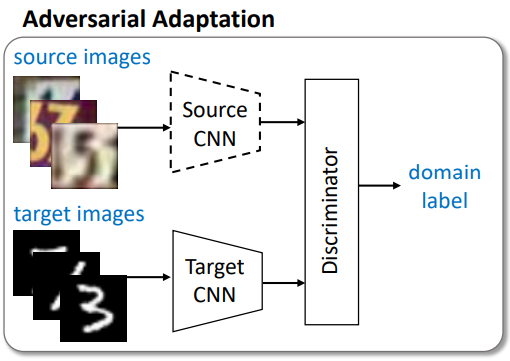










In [ ]:
def train_adversarial_adaptation(
    source_train_loader,
    source_test_loader,
    target_train_loader,
    target_test_loader,
    PRW,
    learning_rate = 0.001, 
    weight_decay = 0.000001, 
    momentum = 0.9, 
    early_stopping=3):
  source_extractor = initialize_resnet18().to(device)
  target_extractor = initialize_resnet18().to(device)

  if PRW:
    source_extractor.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_source_extractor.pt'))
    target_extractor.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_source_extractor.pt'))
  else:
    source_extractor.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_source_extractor.pt'))
    target_extractor.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_source_extractor.pt'))

  #Freeze the source extractor, we don't want to update it
  source_extractor.eval()

  discriminator=Discriminator()
  
  discriminator.to(device)

  #target_optim = torch.optim.Adam(target_extractor.parameters(), lr=0.0001)
  target_optim = get_optimizer(feature_extractor = target_extractor, classifier=None, lr = learning_rate, wd = weight_decay, momentum = momentum)
  discriminator_optim = torch.optim.Adam(discriminator.parameters())

  criterion = nn.CrossEntropyLoss()

  num_epochs = 20
  train_step = 100 #Numero di batch step da fare per ispezionare tutto il train dataset
  val_step = 25 #Numero di batch step da fare per ispezionare tutto il validation dataset
  best_accuracy=0
  patience=0
  discriminator_relevance=1 #Numero di training updates fatti da discriminatore in una sola epoca, aumentandolo si da più importanza al training del discriminatore per mantenere la sfida del generatore difficile
  extractor_loss = []
  discriminator_loss = []

  for epoch in trange(1, num_epochs +1):
    batch_iterator = zip(loop_iterable(source_train_loader), loop_iterable(target_train_loader))
    
    train_loss = 0
    train_accuracy = 0

    train_steps_discr_losses = []
    train_steps_extr_losses = []

    #Training loop
    for _ in range(1,train_step+1):
        # Train discriminator to distinguish between latent representation of source and target domain
        discriminator.train()
        set_requires_grad(discriminator, requires_grad=True)
        target_extractor.eval()
        set_requires_grad(target_extractor, requires_grad=False)

        

        for i in range(discriminator_relevance):
          (source_x, _), (target_x, _) = next(batch_iterator) #Prendi dal dataloader 1 batch (16 immagini) di source e 1 batch (16 immagini) di target
          
          source_x, target_x = source_x.to(device), target_x.to(device)

          source_features = source_extractor(source_x).view(source_x.shape[0], -1) #Latent representation, 512 features
          target_features = target_extractor(target_x).view(target_x.shape[0], -1) #Latent representation, 512 features 

          discriminator_x = torch.cat([source_features, target_features]) #Concatena tensor di samples per creare dataset di training per discriminator
          discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device), torch.zeros(target_x.shape[0], device=device)]) #Crea tensor con i label: 1 per source, 0 per target

          preds = (discriminator(discriminator_x)).squeeze() #Create discriminator prediction
          loss = criterion(preds, discriminator_y) #Compute loss

          train_steps_discr_losses.append(loss.item())

          discriminator_optim.zero_grad()
          loss.backward()
          discriminator_optim.step()

          train_loss += loss.item()
          train_accuracy += ((preds > 0).long() == discriminator_y.long()).float().mean().item()
    
        # Train target model to generate latent representations to fool the discriminator
        target_extractor.train()
        discriminator.eval()
        target_extractor.fc.set_requires_grad=False #Freeze identity layer, update only feature extractor parameters
        set_requires_grad(target_extractor, requires_grad=True)
        
        set_requires_grad(discriminator, requires_grad=False)# Freeze discriminator

        _, (target_x, _) = next(batch_iterator)
        target_x = target_x.to(device)
        target_features = target_extractor(target_x).view(target_x.shape[0], -1)

        # Flip the labels, want to maximize the loss of the discriminator
        discriminator_y = torch.ones(target_x.shape[0], device=device)

        preds = discriminator(target_features).squeeze() #Compute prediction on new extracted features
        loss = criterion(preds, discriminator_y) #Compute extractor loss based on discriminator new predictions

        train_steps_extr_losses.append(loss.item())
        
        target_optim.zero_grad()
        loss.backward()
        target_optim.step()

    #Calculate loss per epoch
    train_loss = train_loss / (train_step*discriminator_relevance)
    train_accuracy = train_accuracy / (train_step*discriminator_relevance)


    extractor_loss.append(sum(train_steps_extr_losses)/len(train_steps_extr_losses))
    discriminator_loss.append(train_loss)


    tqdm.write(f'EPOCH {epoch:03d}: discriminator_train_loss={train_loss:.4f}, '
              f'discriminator_train_accuracy={train_accuracy:.4f},' 
              f'extractor_loss={extractor_loss[-1]:.4f}')
    
    #Save models once training is finished
  if PRW:
    print('Saving discriminator...')
    torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/PRW_discriminator_adversarial.pt')
    print('Saving target generator...')
    torch.save(target_extractor.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/PRW_target_adversarial_extractor.pt')
  else:
    print('Saving discriminator...')
    torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/RWP_discriminator_adversarial.pt')
    print('Saving target generator...')
    torch.save(target_extractor.state_dict(), '/content/gdrive/MyDrive/trained_models/no_crop/RWP_target_adversarial_extractor.pt')

  return discriminator_loss, extractor_loss

## Loss plot

Method for plotting losses of adversarial training

In [ ]:
def plot_losses(sampled_epochs, loss_disc, loss_ext):
  plt.figure(num = 3, figsize=(10, 6)).patch.set_facecolor('white')
  plt.title('Discriminator and Target Extractor Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, loss_disc, label='Discriminator loss')
  plt.plot(sampled_epochs, loss_ext, label='Extractor loss')
  plt.legend()
  plt.show()

# 4) Testing Methods

Methods used for testing accuracy of baseline model and model obtained after adversarial training.

The final model is obtained by using the extractor obtained through adversarial learning and appending the classifier learned during the pretraining phase.


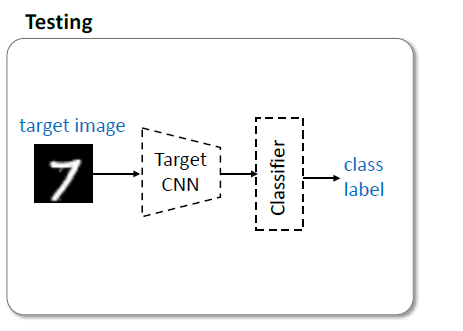

In [ ]:
device = 'cuda:0'

def main_testing(target_test_loader, PRW):
  target_extr = initialize_resnet18().to(device)
  classifier = Classifier().to(device)
  
  if PRW:
    target_extr.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_target_adversarial_extractor.pt'))
    classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_classifier.pt'))
  else:
    target_extr.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_target_adversarial_extractor.pt'))
    classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_classifier.pt'))


  criterion = nn.BCEWithLogitsLoss()

  target_extr.eval()
  classifier.eval()
  with torch.no_grad():
      loss, accuracy, pred, true = test(feature_extractor = target_extr, classifier = classifier, criterion = criterion, dataloader = target_test_loader, optim=None)

  tqdm.write(f'accuracy={accuracy:.4f}')

  return pred, true

In [ ]:
device = 'cuda:0'

def low_bound_testing(target_test_loader, PRW):
  target_extr = initialize_resnet18().to(device)
  classifier = Classifier().to(device)
  
  if PRW:
    target_extr.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/prw_low_bound_extractor.pt'))
    classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/prw_low_bound_classifier.pt'))
  else:
    target_extr.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/rwp_low_bound_extractor.pt'))
    classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/rwp_low_bound_classifier.pt'))

  criterion = nn.BCEWithLogitsLoss()

  target_extr.eval()
  classifier.eval()
  with torch.no_grad():
      loss, accuracy, pred, true = test(feature_extractor = target_extr, classifier = classifier, criterion = criterion, dataloader = target_test_loader, optim=None)

  tqdm.write(f'accuracy={accuracy:.4f}')

  return pred, true

In [ ]:
def test(feature_extractor, classifier, criterion, dataloader, optim=None, device = 'cuda:0'):
  total_loss = 0
  total_accuracy = 0
  total_pred = []
  total_true = []
  for x, y_true in tqdm(dataloader, leave = False):
    x = x.to(device)
    y_true = y_true.to(device)

    y_pred = classifier(feature_extractor(x))

    total_accuracy += (y_pred.max(1)[1] == y_true).float().mean().item()
    
    new_pred = []
    for vect in y_pred:
      new_pred.append(int(torch.argmax(vect)))

    pred = torch.Tensor(new_pred)
    pred = pred.int()
    
    pred = pred.to(device)
    y_true = y_true.int()

    total_pred = total_pred + pred.tolist()
    total_true = total_true + y_true.tolist()


  mean_loss = 0
  mean_accuracy = total_accuracy / len(dataloader)
  return mean_loss, mean_accuracy, total_pred, total_true

# 5) Error Analysis methods

In order to analyze results, we computed confusion matrixes and class accuracy of classification of both baseline and target model.

In addition, we also show through PCA projections how adversarial learning changes feature representation.

##Confusion matrixes

In [ ]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

In [ ]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
def print_cm(pred, true, classes):
  matrix = confusion_matrix(pred, true)
  frame = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])
  plt.figure(figsize = (10,8))
  sn.heatmap(frame, annot=True)

## Feature Visualization using PCA

The assumption with our approach is that through Adversarial Learning we push the feature extractor to generate similar feature representation for both domains by trying to fool the discriminator. In order to see if our assumptions were verified, we performed PCA on samples of the same class (images are taken from *backpack* folder from both real world and product dataset) with both the baseline feature extractor (no domain adaptation strategy) and our proposed model.

Example of backpack samples from the 2 domains


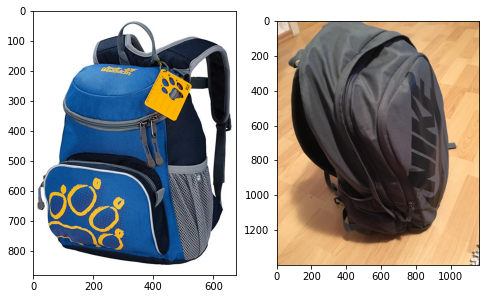

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

product_image=cv2.imread("/content/gdrive/MyDrive/datasets/adaptiope_small/product_images/backpack/backpack_000.jpg")
real_image=cv2.imread("/content/gdrive/MyDrive/datasets/adaptiope_small/real_life/backpack/backpack_000.jpg")

product_image_display=cv2.cvtColor(product_image, cv2.COLOR_BGR2RGB)
real_image_display=cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)


transform = T.Compose([T.ToTensor()])
product_image=transform(product_image).to(device)
real_image=transform(real_image).to(device)

columns=2
rows=1

fig.add_subplot(rows, columns, 1)
plt.imshow(product_image_display)

fig.add_subplot(rows, columns, 2)
plt.imshow(real_image_display)

print("Example of backpack samples from the 2 domains")

plt.show()

In [ ]:
import os

def get_backpack_tensors():
  transforms = list()
  transforms.append(T.ToPILImage())
  transforms.append(T.Resize((IMAGE_SIZE, IMAGE_SIZE)))                      # resize each PIL image to 256 x 256
  transforms.append(T.ToTensor())                                            # convert Numpy to Pytorch Tensor
  transforms = T.Compose(transforms)

  product_backpack=[]
  real_backpack=[]
  dir_path="/content/gdrive/MyDrive/datasets/adaptiope_small/product_images/backpack"

  for path in os.listdir(dir_path):
      # check if current path is a file
      file_path=os.path.join(dir_path, path)
      if os.path.isfile(file_path):
          image=cv2.imread(file_path)
          image=transforms(image)
          product_backpack.append(image)

  dir_path="/content/gdrive/MyDrive/datasets/adaptiope_small/real_life/backpack"
  for path in os.listdir(dir_path):
      # check if current path is a file
      file_path=os.path.join(dir_path, path)
      if os.path.isfile(file_path):
          image=cv2.imread(file_path)
          image=transforms(image)
          real_backpack.append(image)

  stack_product_backpack=torch.stack(product_backpack).to(device)
  stack_real_backpack=torch.stack(real_backpack).to(device)
  return stack_product_backpack, stack_real_backpack

In [ ]:
def perform_pca(data,n_components):
  U,S,V=torch.pca_lowrank(data,n_components)
  projections=torch.matmul(data, V[:, :n_components]) #projects data to the first n principal components
  projections=projections.tolist()
  return projections

In [ ]:
from matplotlib.lines import Line2D  

def display_points(data1,data2,adaptation,name1,name2):
  plt.figure(figsize=(8,8))
  plt.clf()
  legend_elements = [Line2D([0], [0], color='red', lw=4, label=name1),
                       Line2D([0], [0], color='blue', lw=4, label=name2)]
  for x,y in data1:
    plt.scatter(x,y,color='red')
  for x,y in data2:
    plt.scatter(x,y,color='blue')
  if(adaptation==False):
    plt.title("Feature Alignment before domain adapatation")
  else:
    plt.title("Feature Alignment after domain adaptation")

  plt.legend(handles=legend_elements)
  #plt.legend(legend)
  plt.show()

In [ ]:
#ATTENZIONE, carica immagini senza dataloader in memoria, consuma velocemente memoria di colab, usato per calcolare PCA
stack_product_backpack,stack_real_backpack=get_backpack_tensors()

# 6) Product to Real World Domain Adaptation

##Upper bound
Upper bound for domain adaptation from product to real world. Obtained by training using labels on real world images and testing on real world samples


In [ ]:
#Product to real world upper bound
PRW_up_pred, PRW_up_true = main_upperbound(target_train_loader = real_train_loader, target_test_loader = real_test_loader,PRW=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 001: train_loss=1.5573, train_accuracy=0.5625 val_loss=0.4649, val_accuracy=0.8650
Saving model...


EPOCH 002: train_loss=0.3571, train_accuracy=0.9175 val_loss=0.3433, val_accuracy=0.9050
Saving model...


EPOCH 003: train_loss=0.1556, train_accuracy=0.9738 val_loss=0.3248, val_accuracy=0.9075
Saving model...


EPOCH 004: train_loss=0.0759, train_accuracy=0.9919 val_loss=0.2492, val_accuracy=0.9275
Saving model...


EPOCH 005: train_loss=0.0656, train_accuracy=0.9900 val_loss=0.3206, val_accuracy=0.8900
Saving model...


EPOCH 006: train_loss=0.0387, train_accuracy=0.9969 val_loss=0.2455, val_accuracy=0.9300
Saving model...


EPOCH 007: train_loss=0.0411, train_accuracy=0.9956 val_loss=0.2466, val_accuracy=0.9275
Saving model...


EPOCH 008: train_loss=0.0349, train_accuracy=0.9975 val_loss=0.2308, val_accuracy=0.9250
Saving model...


EPOCH 009: train_loss=0.0316, train_accuracy=0.9981 val_loss=0.2675, val_accuracy=0.9100
EARLY STOPPING: stopped training after  3  epochs without improvements
BEST_ EPOCH 006: train_loss=0.0387, train_accuracy=0.9969 val_loss=0.2455, val_accuracy=0.9300
Saving model...


##Lower Bound
Lower bound for domain adaptation from product to real world. Obtained by training using labels on product images and testing on real world samples



> Product to Real World



In [ ]:
#Product to real world lower bound
PRW_low_pred, PRW_low_true = main_lowerbound(source_train_loader = product_train_loader, target_test_loader = real_test_loader,PRW=True)

In [ ]:
baseline_pred,baseline_true=low_bound_testing(target_test_loader=real_test_loader, PRW=True)
prw_baseline_score=accuracy_score(baseline_true, baseline_pred)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
                                               

accuracy=0.7025


In [ ]:
report = classification_report(baseline_pred, baseline_true, target_names = classes, output_dict=True)
baseline_class_accuracy={}
discard_keys=['accuracy', 'macro avg', 'weighted avg']
for item in report.keys():
  if item not in discard_keys:
    accuracy=report[item]['precision']
    baseline_class_accuracy[item]=accuracy
baseline_table = pd.DataFrame.from_dict(report)
baseline_table.transpose()

,precision,recall,f1-score,support
backpack,0.894737,0.607143,0.723404,28.0000
bookcase,0.565217,1.000000,0.722222,13.0000
car jack,0.769231,0.666667,0.714286,30.0000
comb,0.590909,0.812500,0.684211,16.0000
crown,0.789474,0.714286,0.750000,21.0000
file cabinet,0.666667,0.666667,0.666667,18.0000
flat iron,0.681818,0.882353,0.769231,17.0000
game controller,0.947368,0.642857,0.765957,28.0000
glasses,0.375000,1.000000,0.545455,6.0000
helicopter,0.636364,1.000000,0.777778,14.0000


## Pretraining

> Train Source Model on **Product**



In [ ]:
main_pretraining(source_train_loader = product_train_loader, source_test_loader = product_test_loader, PRW=True) 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 001: train_loss=1.1379, train_accuracy=0.7100 val_loss=0.1698, val_accuracy=0.9525
Saving model...


EPOCH 002: train_loss=0.1873, train_accuracy=0.9631 val_loss=0.1384, val_accuracy=0.9625
Saving model...


EPOCH 003: train_loss=0.0885, train_accuracy=0.9875 val_loss=0.1346, val_accuracy=0.9650
Saving model...


EPOCH 004: train_loss=0.0522, train_accuracy=0.9931 val_loss=0.1363, val_accuracy=0.9675
Saving model...


EPOCH 005: train_loss=0.0402, train_accuracy=0.9956 val_loss=0.1166, val_accuracy=0.9725
Saving model...


EPOCH 006: train_loss=0.0270, train_accuracy=0.9994 val_loss=0.0974, val_accuracy=0.9750
Saving model...


EPOCH 007: train_loss=0.0266, train_accuracy=0.9975 val_loss=0.1313, val_accuracy=0.9650


EPOCH 008: train_loss=0.0242, train_accuracy=0.9994 val_loss=0.1058, val_accuracy=0.9825
Saving model...


EPOCH 009: train_loss=0.0309, train_accuracy=0.9969 val_loss=0.1251, val_accuracy=0.9675


EPOCH 010: train_loss=0.0224, train_accuracy=1.0000 val_loss=0.0916, val_accuracy=0.9825


## Adversarial Training

As we can see, the discriminator is consistently able to correctly distinguish the 2 representations.

In some runs we obtained a lower discriminator accuracy during the adversarial phase ( ≈55%). However, we found no correlation between the discriminator accuracy in this stage and the final results on the UDA task.

Also, we tried increasing the number of epochs but did not notice any change in the training behaviour.

In [ ]:
#Product to Real world
discriminator_loss, extractor_loss = train_adversarial_adaptation(
    source_train_loader = product_train_loader, 
    source_test_loader = product_test_loader,
    target_train_loader = real_train_loader,
    target_test_loader = real_test_loader,
    PRW=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  5%|▌         | 1/20 [03:01<57:29, 181.56s/it]

EPOCH 001: discriminator_train_loss=53.7361, discriminator_train_accuracy=0.6800,extractor_loss=45.1531


 10%|█         | 2/20 [06:01<54:07, 180.40s/it]

EPOCH 002: discriminator_train_loss=49.8932, discriminator_train_accuracy=0.8644,extractor_loss=46.7977


 15%|█▌        | 3/20 [09:00<50:56, 179.79s/it]

EPOCH 003: discriminator_train_loss=48.4674, discriminator_train_accuracy=0.9172,extractor_loss=48.0384


 20%|██        | 4/20 [11:59<47:51, 179.46s/it]

EPOCH 004: discriminator_train_loss=47.3468, discriminator_train_accuracy=0.9481,extractor_loss=49.6617


 25%|██▌       | 5/20 [14:58<44:51, 179.42s/it]

EPOCH 005: discriminator_train_loss=46.7505, discriminator_train_accuracy=0.9753,extractor_loss=50.9762


 30%|███       | 6/20 [17:57<41:51, 179.38s/it]

EPOCH 006: discriminator_train_loss=46.3163, discriminator_train_accuracy=0.9784,extractor_loss=52.2409


 35%|███▌      | 7/20 [20:57<38:53, 179.52s/it]

EPOCH 007: discriminator_train_loss=45.8120, discriminator_train_accuracy=0.9816,extractor_loss=53.8964


 40%|████      | 8/20 [23:57<35:53, 179.48s/it]

EPOCH 008: discriminator_train_loss=45.7297, discriminator_train_accuracy=0.9872,extractor_loss=55.5704


 45%|████▌     | 9/20 [26:56<32:55, 179.58s/it]

EPOCH 009: discriminator_train_loss=45.4524, discriminator_train_accuracy=0.9900,extractor_loss=55.9305


 50%|█████     | 10/20 [29:56<29:56, 179.63s/it]

EPOCH 010: discriminator_train_loss=45.3537, discriminator_train_accuracy=0.9872,extractor_loss=56.7001


 55%|█████▌    | 11/20 [32:55<26:55, 179.55s/it]

EPOCH 011: discriminator_train_loss=45.2922, discriminator_train_accuracy=0.9831,extractor_loss=57.3776


 60%|██████    | 12/20 [35:55<23:56, 179.56s/it]

EPOCH 012: discriminator_train_loss=45.1010, discriminator_train_accuracy=0.9903,extractor_loss=57.5287


 65%|██████▌   | 13/20 [38:54<20:56, 179.46s/it]

EPOCH 013: discriminator_train_loss=45.0436, discriminator_train_accuracy=0.9894,extractor_loss=58.4040


 70%|███████   | 14/20 [41:54<17:57, 179.55s/it]

EPOCH 014: discriminator_train_loss=45.0021, discriminator_train_accuracy=0.9838,extractor_loss=59.2183


 75%|███████▌  | 15/20 [44:53<14:57, 179.46s/it]

EPOCH 015: discriminator_train_loss=44.9559, discriminator_train_accuracy=0.9856,extractor_loss=60.4235


 80%|████████  | 16/20 [47:53<11:58, 179.57s/it]

EPOCH 016: discriminator_train_loss=44.8598, discriminator_train_accuracy=0.9803,extractor_loss=62.7677


 85%|████████▌ | 17/20 [50:55<09:00, 180.21s/it]

EPOCH 017: discriminator_train_loss=44.7992, discriminator_train_accuracy=0.9844,extractor_loss=62.7255


 90%|█████████ | 18/20 [53:52<05:58, 179.46s/it]

EPOCH 018: discriminator_train_loss=44.7367, discriminator_train_accuracy=0.9819,extractor_loss=65.0016


 95%|█████████▌| 19/20 [56:50<02:58, 178.96s/it]

EPOCH 019: discriminator_train_loss=44.6878, discriminator_train_accuracy=0.9822,extractor_loss=65.4843


100%|██████████| 20/20 [59:48<00:00, 179.40s/it]

EPOCH 020: discriminator_train_loss=44.6753, discriminator_train_accuracy=0.9856,extractor_loss=66.3037
Saving discriminator...
Saving target generator...


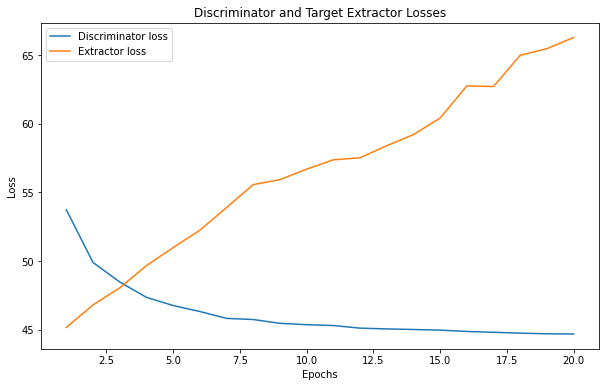

In [ ]:
plot_losses(list(range(1,21)), discriminator_loss, extractor_loss)

## Testing

Testing the model on the real world test dataset.



> Obtained accuracy: **82.75%**



In [ ]:
PRW_pred, PRW_true = main_testing(target_test_loader=real_test_loader, PRW=True)
prw_adversarial_score=accuracy_score(PRW_true, PRW_pred)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                               

accuracy=0.8275


## Error Analysis

### Class Accuracy

In [ ]:
report = classification_report(PRW_pred, PRW_true, target_names = classes, output_dict=True)
adv_class_accuracy={}
discard_keys=['accuracy', 'macro avg', 'weighted avg']
for item in report.keys():
  if item not in discard_keys:
    accuracy=report[item]['precision']
    adv_class_accuracy[item]=accuracy
    #print(item, adv_class_accuracy[item])
adv_table = pd.DataFrame.from_dict(report)
adv_table.transpose()

,precision,recall,f1-score,support
backpack,0.842105,0.941176,0.888889,17.0000
bookcase,0.913043,0.875000,0.893617,24.0000
car jack,0.807692,0.724138,0.763636,29.0000
comb,0.863636,0.760000,0.808511,25.0000
crown,0.894737,0.944444,0.918919,18.0000
file cabinet,0.833333,0.937500,0.882353,16.0000
flat iron,0.863636,0.826087,0.844444,23.0000
game controller,0.842105,1.000000,0.914286,16.0000
glasses,0.687500,0.785714,0.733333,14.0000
helicopter,0.863636,1.000000,0.926829,19.0000


### Gain



> Obtained **12.50%** increase in accuracy over baseline model



In [ ]:
gain=prw_adversarial_score-prw_baseline_score
print("Baseline accuracy =", prw_baseline_score)
print("Domain Adaptation accuracy=", prw_adversarial_score)
print("Gain=",gain)

Baseline accuracy = 0.7025
Domain Adaptation accuracy= 0.8275
Gain= 0.125


In [ ]:
print("Comparing Target Model with Baseline")
gain={}
for label in adv_class_accuracy:
  gain[label]=adv_class_accuracy[label]-baseline_class_accuracy[label]
column=["Accuracy Gain"]
df = pd.DataFrame(gain.values(), index=gain.keys(), columns=column)
df

Comparing Target Model with Baseline


,Accuracy Gain
backpack,-0.052632
bookcase,0.347826
car jack,0.038462
comb,0.272727
crown,0.105263
file cabinet,0.166667
flat iron,0.181818
game controller,-0.105263
glasses,0.312500
helicopter,0.227273


It's interesting to note that, of the 20 classes, 13 obtain an accuracy score improvement thanks to the domain adaptation technique. One class maintains it's previous score, and 6 classes perform slightly worse.

### Confusion Matrixes

Lower Bound

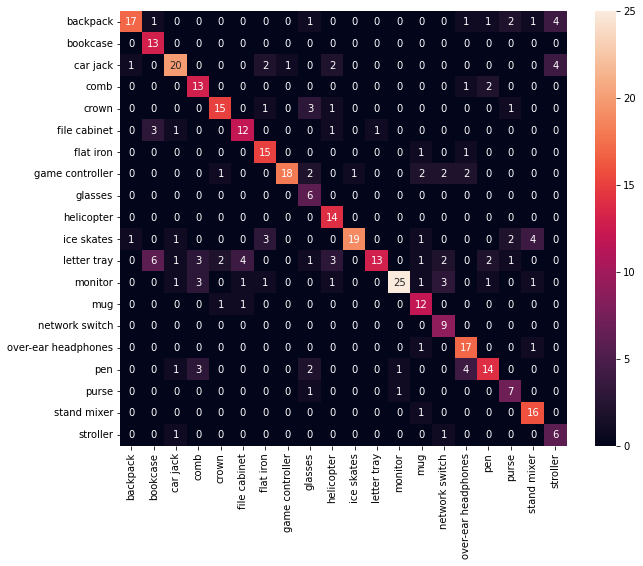

In [ ]:
print_cm(baseline_pred, baseline_true, classes)

Domain Adaptation Model

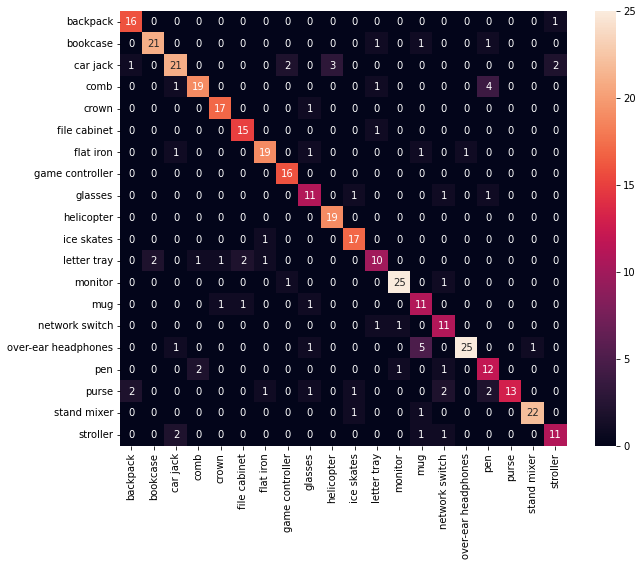

In [ ]:
print_cm(PRW_pred, PRW_true,classes)

### PCA

As the plot shows, the baseline model produce features from samples of the same class but different domains  that are distinct from each other. We can see a clear separation into 2 clusters.

Whereas, using the model that underwent Adversarial Domain Adaptation, the projected samples coming from different domains tend to mix between each other, making us believe that the model is able to generate domain-invariant features for objects of the same class.

In [ ]:
#Load models and data
baseline_product=initialize_resnet18().to(device)
baseline_product.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_source_extractor.pt'))

prw=initialize_resnet18().to(device)
prw.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/PRW_target_adversarial_extractor.pt'))

prw.eval()
baseline_product.eval()
n_components=2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


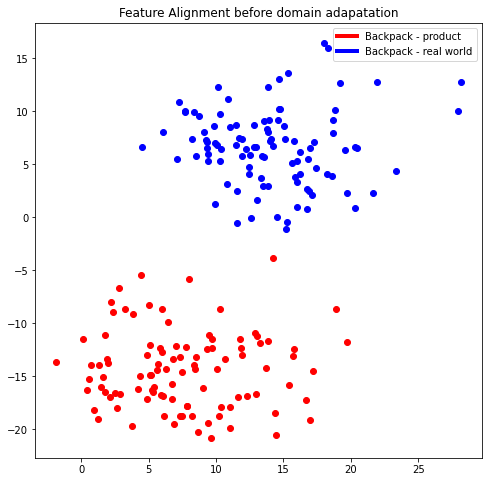

In [ ]:
latent_representation_product=baseline_product(stack_product_backpack)
latent_representation_real=baseline_product(stack_real_backpack)

no_da_product=perform_pca(latent_representation_product,n_components)
no_da_real=perform_pca(latent_representation_real,n_components)

display_points(no_da_product,no_da_real,False,"Backpack - product","Backpack - real world")

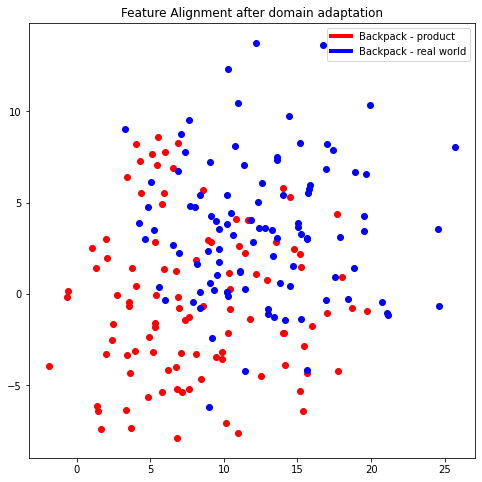

In [ ]:
latent_representation_adversarial_product=prw(stack_product_backpack)
latent_representation_adversarial_real=prw(stack_real_backpack)

da_product=perform_pca(latent_representation_adversarial_product,n_components)
da_real=perform_pca(latent_representation_adversarial_real,n_components)

display_points(da_product,da_real,True,"Backpack - product","Backpack - real world")

# 7) Real World to Product Domain Adaptation 

##Upper bound
Upper bound for domain adaptation from real world to product. Obtained by training using labels on product images and testing on product samples


In [ ]:
#Product upper bound
RWP_up_pred, RWP_up_true = main_upperbound(target_train_loader = product_train_loader, target_test_loader = product_test_loader,PRW=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 001: train_loss=1.0100, train_accuracy=0.7400 val_loss=0.1735, val_accuracy=0.9575
Saving model...


EPOCH 002: train_loss=0.1580, train_accuracy=0.9694 val_loss=0.1443, val_accuracy=0.9625
Saving model...


EPOCH 003: train_loss=0.0715, train_accuracy=0.9875 val_loss=0.1124, val_accuracy=0.9750
Saving model...


EPOCH 004: train_loss=0.0551, train_accuracy=0.9925 val_loss=0.1200, val_accuracy=0.9700
Saving model...


EPOCH 005: train_loss=0.0324, train_accuracy=0.9975 val_loss=0.1164, val_accuracy=0.9675
Saving model...


EPOCH 006: train_loss=0.0406, train_accuracy=0.9938 val_loss=0.1169, val_accuracy=0.9650
EARLY STOPPING: stopped training after  3  epochs without improvements
BEST_ EPOCH 003: train_loss=0.0715, train_accuracy=0.9875 val_loss=0.1124, val_accuracy=0.9750
Saving model...


##Lower Bound
Lower bound for domain adaptation from real world to product. Obtained by training using labels on real world images and testing on product samples

> Real World to Product



In [ ]:
#Product lower bound
RWP_low_pred, RWP_low_true = main_lowerbound(source_train_loader = real_train_loader, target_test_loader = product_test_loader,PRW=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


EPOCH 001: train_loss=1.5956, train_accuracy=0.5544 val_loss=0.3782, val_accuracy=0.9125
Saving model...


EPOCH 002: train_loss=0.3792, train_accuracy=0.9075 val_loss=0.3453, val_accuracy=0.9125
Saving model...


EPOCH 003: train_loss=0.1561, train_accuracy=0.9712 val_loss=0.3541, val_accuracy=0.8975
EARLY STOPPING: stopped training after  2  epochs without improvements
BEST_ EPOCH 001: train_loss=1.5956, train_accuracy=0.5544 val_loss=0.3782, val_accuracy=0.9125
Saving model...


In [ ]:
baseline_pred,baseline_true=low_bound_testing(target_test_loader=product_test_loader, PRW=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
                                               

accuracy=0.8975


In [ ]:
rwp_baseline_score=accuracy_score(baseline_true, baseline_pred)
report = classification_report(baseline_pred, baseline_true, target_names = classes, output_dict=True)
baseline_class_accuracy={}
discard_keys=['accuracy', 'macro avg', 'weighted avg']
for item in report.keys():
  if item not in discard_keys:
    accuracy=report[item]['precision']
    baseline_class_accuracy[item]=accuracy
baseline_table = pd.DataFrame.from_dict(report)
baseline_table.transpose()

,precision,recall,f1-score,support
backpack,0.882353,0.833333,0.857143,18.0000
bookcase,0.650000,1.000000,0.787879,13.0000
car jack,0.666667,1.000000,0.800000,10.0000
comb,1.000000,0.954545,0.976744,22.0000
crown,0.954545,1.000000,0.976744,21.0000
file cabinet,1.000000,0.933333,0.965517,15.0000
flat iron,0.684211,0.928571,0.787879,14.0000
game controller,1.000000,0.925926,0.961538,27.0000
glasses,1.000000,0.789474,0.882353,19.0000
helicopter,0.894737,1.000000,0.944444,17.0000


As seen by the results, the Lower Bound for real world to product is performing way better compared to the Lower Bound from product to real world



*   Product to Real world ≈ 70.25% 
*   Real world to Product ≈ 89.75%

Since the same architecture in both experiments is used, we believe the boost in lower bound performance is given by the dataset itself.
Infact, by looking at the real world dataset, the samples overall contain more diversity of details. Some items appear worn/used, there are different angles of view, light conditions and background information that help the feature extractor in learning a more generalized representation.


## Pre-Training

> Train Source Model on **Real World**



In [ ]:
main_pretraining(source_train_loader = real_train_loader, source_test_loader = real_test_loader, PRW=False) 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH 001: train_loss=1.5293, train_accuracy=0.5681 val_loss=0.4537, val_accuracy=0.8950
Saving model...


EPOCH 002: train_loss=0.3662, train_accuracy=0.9094 val_loss=0.3698, val_accuracy=0.8975
Saving model...


EPOCH 003: train_loss=0.1460, train_accuracy=0.9706 val_loss=0.2808, val_accuracy=0.9250
Saving model...


EPOCH 004: train_loss=0.0826, train_accuracy=0.9900 val_loss=0.2807, val_accuracy=0.9225


EPOCH 005: train_loss=0.0568, train_accuracy=0.9956 val_loss=0.3019, val_accuracy=0.9100


EPOCH 006: train_loss=0.0509, train_accuracy=0.9938 val_loss=0.2781, val_accuracy=0.9275
Saving model...


EPOCH 007: train_loss=0.0350, train_accuracy=0.9988 val_loss=0.3270, val_accuracy=0.9150


EPOCH 008: train_loss=0.0381, train_accuracy=0.9969 val_loss=0.2685, val_accuracy=0.9225


EPOCH 009: train_loss=0.0382, train_accuracy=0.9969 val_loss=0.3856, val_accuracy=0.9000
EARLY STOPPING: stopped training after  3  epochs without improvements
BEST_ EPOCH 006: train_loss=0.0509, train_accuracy=0.9938 val_loss=0.2781, val_accuracy=0.9275


## Adversarial Training

In [ ]:
#Real world to product
discriminator_loss, extractor_loss = train_adversarial_adaptation(
    source_train_loader = real_train_loader, 
    source_test_loader = real_test_loader,
    target_train_loader = product_train_loader,
    target_test_loader = product_test_loader,
    PRW=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  5%|▌         | 1/20 [02:57<56:08, 177.27s/it]

EPOCH 001: discriminator_train_loss=54.9958, discriminator_train_accuracy=0.5150,extractor_loss=44.6729


 10%|█         | 2/20 [05:54<53:06, 177.02s/it]

EPOCH 002: discriminator_train_loss=53.7283, discriminator_train_accuracy=0.5509,extractor_loss=45.0800


 15%|█▌        | 3/20 [08:51<50:09, 177.02s/it]

EPOCH 003: discriminator_train_loss=51.9436, discriminator_train_accuracy=0.6575,extractor_loss=46.1526


 20%|██        | 4/20 [11:48<47:14, 177.19s/it]

EPOCH 004: discriminator_train_loss=50.5226, discriminator_train_accuracy=0.7366,extractor_loss=47.0481


 25%|██▌       | 5/20 [14:46<44:20, 177.37s/it]

EPOCH 005: discriminator_train_loss=49.5548, discriminator_train_accuracy=0.8300,extractor_loss=47.9495


 30%|███       | 6/20 [17:43<41:22, 177.34s/it]

EPOCH 006: discriminator_train_loss=48.8190, discriminator_train_accuracy=0.8691,extractor_loss=49.2557


 35%|███▌      | 7/20 [20:40<38:25, 177.34s/it]

EPOCH 007: discriminator_train_loss=48.1423, discriminator_train_accuracy=0.9122,extractor_loss=50.4835


 40%|████      | 8/20 [23:38<35:28, 177.34s/it]

EPOCH 008: discriminator_train_loss=47.2940, discriminator_train_accuracy=0.9525,extractor_loss=52.0092


 45%|████▌     | 9/20 [26:35<32:29, 177.20s/it]

EPOCH 009: discriminator_train_loss=47.2928, discriminator_train_accuracy=0.9447,extractor_loss=52.8722


 50%|█████     | 10/20 [29:32<29:32, 177.21s/it]

EPOCH 010: discriminator_train_loss=47.0431, discriminator_train_accuracy=0.9475,extractor_loss=53.6866


 55%|█████▌    | 11/20 [32:29<26:34, 177.13s/it]

EPOCH 011: discriminator_train_loss=46.6306, discriminator_train_accuracy=0.9637,extractor_loss=55.1905


 60%|██████    | 12/20 [35:26<23:37, 177.13s/it]

EPOCH 012: discriminator_train_loss=46.2764, discriminator_train_accuracy=0.9722,extractor_loss=56.5504


 65%|██████▌   | 13/20 [38:23<20:39, 177.09s/it]

EPOCH 013: discriminator_train_loss=46.2696, discriminator_train_accuracy=0.9725,extractor_loss=57.9942


 70%|███████   | 14/20 [41:20<17:42, 177.12s/it]

EPOCH 014: discriminator_train_loss=46.1642, discriminator_train_accuracy=0.9666,extractor_loss=57.4750


 75%|███████▌  | 15/20 [44:17<14:45, 177.15s/it]

EPOCH 015: discriminator_train_loss=45.6742, discriminator_train_accuracy=0.9825,extractor_loss=59.5953


 80%|████████  | 16/20 [47:14<11:48, 177.11s/it]

EPOCH 016: discriminator_train_loss=45.4818, discriminator_train_accuracy=0.9850,extractor_loss=61.0411


 85%|████████▌ | 17/20 [50:12<08:51, 177.23s/it]

EPOCH 017: discriminator_train_loss=45.5214, discriminator_train_accuracy=0.9816,extractor_loss=61.9979


 90%|█████████ | 18/20 [53:09<05:54, 177.18s/it]

EPOCH 018: discriminator_train_loss=45.2943, discriminator_train_accuracy=0.9844,extractor_loss=63.4308


 95%|█████████▌| 19/20 [56:07<02:57, 177.46s/it]

EPOCH 019: discriminator_train_loss=45.2509, discriminator_train_accuracy=0.9847,extractor_loss=64.6557


100%|██████████| 20/20 [59:06<00:00, 177.32s/it]


EPOCH 020: discriminator_train_loss=45.3288, discriminator_train_accuracy=0.9803,extractor_loss=66.6772
Saving discriminator...
Saving target generator...


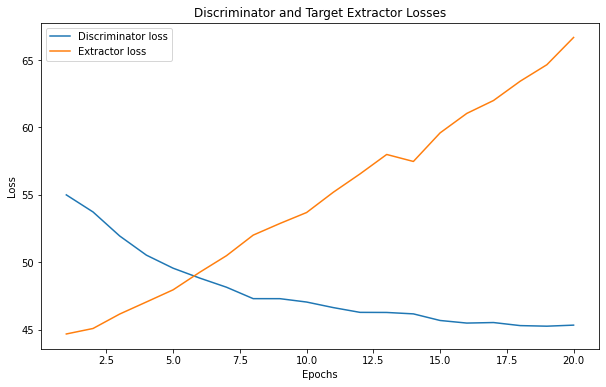

In [ ]:
plot_losses(list(range(1,21)), discriminator_loss, extractor_loss)

##Testing

Testing the model on the product test dataset.



> Obtained accuracy: **92.00%**

In [ ]:
RWP_pred, RWP_true = main_testing(target_test_loader=product_test_loader, PRW=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
                                               

accuracy=0.9200


## Error Analysis

### Class Accuracy

In [ ]:
report = classification_report(RWP_pred, RWP_true, target_names = classes, output_dict=True)
adv_class_accuracy={}
discard_keys=['accuracy', 'macro avg', 'weighted avg']
for item in report.keys():
  if item not in discard_keys:
    accuracy=report[item]['precision']
    adv_class_accuracy[item]=accuracy
adv_table = pd.DataFrame.from_dict(report)
adv_table.transpose()

,precision,recall,f1-score,support
backpack,0.705882,0.923077,0.800000,13.00
bookcase,0.850000,0.850000,0.850000,20.00
car jack,1.000000,0.882353,0.937500,17.00
comb,0.952381,0.869565,0.909091,23.00
crown,0.909091,1.000000,0.952381,20.00
file cabinet,0.857143,0.857143,0.857143,14.00
flat iron,0.894737,1.000000,0.944444,17.00
game controller,1.000000,0.925926,0.961538,27.00
glasses,1.000000,0.937500,0.967742,16.00
helicopter,0.894737,1.000000,0.944444,17.00


In [ ]:
print("Comparing Target Model with Baseline")
gain={}
for label in adv_class_accuracy:
  gain[label]=adv_class_accuracy[label]-baseline_class_accuracy[label]
column=["Accuracy Gain"]
df = pd.DataFrame(gain.values(), index=gain.keys(), columns=column)
df

Comparing Target Model with Baseline


,Accuracy Gain
backpack,-0.176471
bookcase,0.200000
car jack,0.333333
comb,-0.047619
crown,-0.045455
file cabinet,-0.142857
flat iron,0.210526
game controller,0.000000
glasses,0.000000
helicopter,0.000000


### Gain

> Obtained **2.25%** increase in accuracy over baseline model

In [ ]:
rwp_adversarial_score=accuracy_score(RWP_true, RWP_pred)
gain=rwp_adversarial_score-rwp_baseline_score
print("Baseline accuracy =", rwp_baseline_score)
print("Domain Adaptation accuracy=", rwp_adversarial_score)
print("Gain=",gain)

Baseline accuracy = 0.8975
Domain Adaptation accuracy= 0.92
Gain= 0.022500000000000075


###Confusion Matrixes

Lower Bound: 

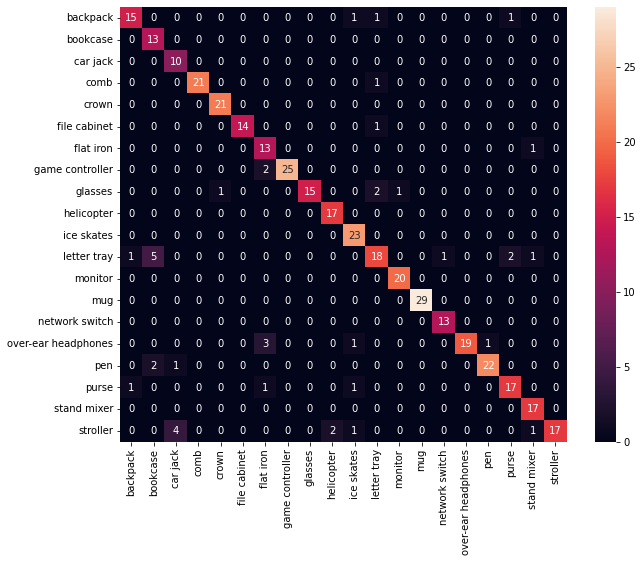

In [ ]:
print_cm(baseline_pred, baseline_true, classes)

Final model:

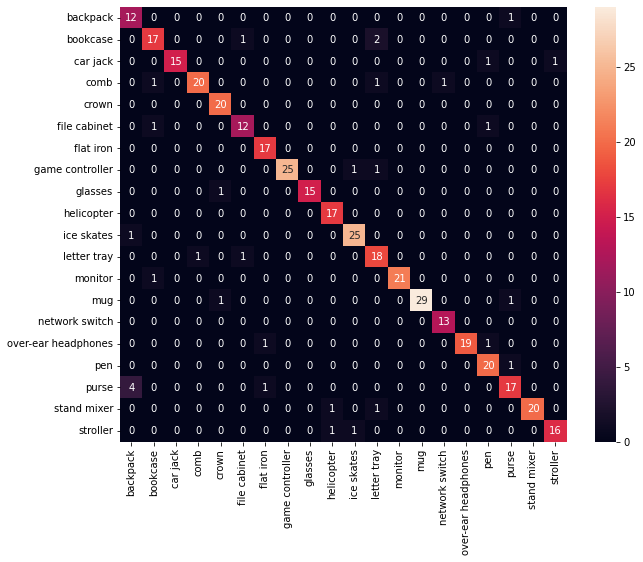

In [ ]:
print_cm(RWP_pred, RWP_true,classes)

Lower bound results per class:

In [ ]:
report = classification_report(baseline_true, baseline_pred, target_names = classes, output_dict=True)
table = pd.DataFrame.from_dict(report)
table.transpose()

,precision,recall,f1-score,support
backpack,0.833333,0.882353,0.857143,17.0000
bookcase,1.000000,0.650000,0.787879,20.0000
car jack,1.000000,0.666667,0.800000,15.0000
comb,0.954545,1.000000,0.976744,21.0000
crown,1.000000,0.954545,0.976744,22.0000
file cabinet,0.933333,1.000000,0.965517,14.0000
flat iron,0.928571,0.684211,0.787879,19.0000
game controller,0.925926,1.000000,0.961538,25.0000
glasses,0.789474,1.000000,0.882353,15.0000
helicopter,1.000000,0.894737,0.944444,19.0000


Final model results per class:

In [ ]:
report = classification_report(RWP_true, RWP_pred, target_names = classes, output_dict=True)
table = pd.DataFrame.from_dict(report)
table.transpose()

,precision,recall,f1-score,support
backpack,0.923077,0.705882,0.800000,17.00
bookcase,0.850000,0.850000,0.850000,20.00
car jack,0.882353,1.000000,0.937500,15.00
comb,0.869565,0.952381,0.909091,21.00
crown,1.000000,0.909091,0.952381,22.00
file cabinet,0.857143,0.857143,0.857143,14.00
flat iron,1.000000,0.894737,0.944444,19.00
game controller,0.925926,1.000000,0.961538,25.00
glasses,0.937500,1.000000,0.967742,15.00
helicopter,1.000000,0.894737,0.944444,19.00


###PCA

As already mentioned above, the plots show how the Adversarial Domain Adaptation process achieves the objective of obtaining similar features from samples of the same class but different domains.

In the first plot, the features are generated by the baseline model.

In the second plot, the features are generated by the target model.

In [ ]:
#Load models and data
baseline_real=initialize_resnet18().to(device)
baseline_real.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_source_extractor.pt'))

rwp=initialize_resnet18().to(device)
rwp.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_models/no_crop/RWP_target_adversarial_extractor.pt'))

rwp.eval()
baseline_real.eval()
n_components=2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


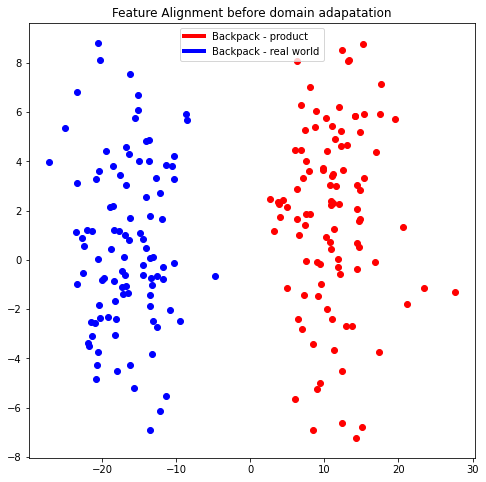

In [ ]:
latent_representation_product=baseline_real(stack_product_backpack)
latent_representation_real=baseline_real(stack_real_backpack)

no_da_product=perform_pca(latent_representation_product,n_components)
no_da_real=perform_pca(latent_representation_real,n_components)

display_points(no_da_product,no_da_real,False,"Backpack - product","Backpack - real world")

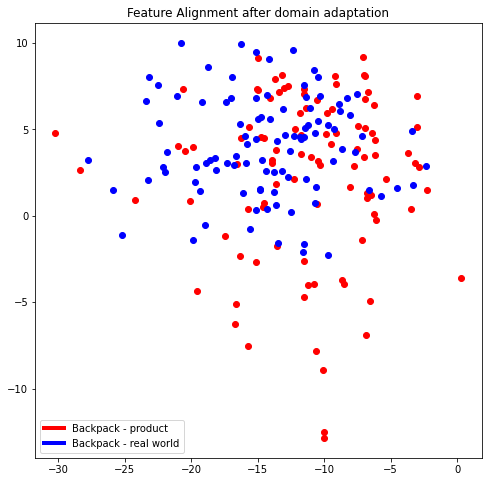

In [ ]:
latent_representation_adversarial_product=rwp(stack_product_backpack)
latent_representation_adversarial_real=rwp(stack_real_backpack)

da_product=perform_pca(latent_representation_adversarial_product,n_components)
da_real=perform_pca(latent_representation_adversarial_real,n_components)

display_points(da_product,da_real,True,"Backpack - product","Backpack - real world")

# 8) Conclusions

Our model obtains quite good results in both directions of domain adaptation. From *product* to *real world* domain, it achieve an accuracy of `82.75%` with a gain on the baseline of `12.50%`. From *real world* to *product* domain, instead, it achieves an accuracy of `92.00%` with a gain of `2.25%` over the baseline. 

We encontered the main difficulties in working with an adversarial training setting. It was hard to find the best setting of training parameters because by slightly changing a single parameter we can obtain very different results.
For example, changes in the weight decay value caused improvements from real world to product but a significant drop from product to real world.

In order to have a general evaluation on a unique model, we decided to use the same parameters in both directions.

In addition to that, we found very little correlation between the discriminator accuracy in the adversarial training and the final accuracy obtained on the UDA task.

Finally, another minor issue we encountered is that the results could quite change depending on how samples are randomly split when dataloaders are created. We believe this is linked to the size of dataset that, given the number of classes, it's not so big. 



|                               	| Product to Real World 	| Real World to Product 	|   	|   	|
|-------------------------------	|-----------------------	|-----------------------	|---	|---	|
| **Source Only**                   	| 70.25%          	| 89.75%          	|   	|   	|
| **Adversarial Domain Adaptation** 	| 82.75%             	| 92.00%             	|   	|   	|


#9) Extra

Here we have some methods we used to istantiate different model backbones, in the end we used Resnet-18 as it brought the best tradeoff in terms of complexity and accuracy.

##Net class

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 20),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        #print("features1 shape: ", features.shape)
        features = features.view(x.shape[0], -1) #reshape the tensor with 16 columns (batch_size) and the necessary number of rows
        #features = features.view(1, -1) #reshape the tensor with 3 columns and the necessary number of rows
        #print("features2 size: ", features.shape)
        logits = self.classifier(features)
        #print("logits: ", logits)

        
        return logits

##AlexNet

In [ ]:
def initialize_alexnet(num_classes):

  # load the pre-trained Alexnet
  alexnet = torchvision.models.alexnet(pretrained=True) #define that we want pretrained weights
  # get the number of neurons in the second last layer
  in_features = alexnet.classifier[6].in_features #we acces the classifier attribute and then index the last layer (linear layer is the seventh) 
  
  # re-initalize the output layer
  alexnet.classifier[6] = torch.nn.Linear(in_features=in_features, 
                                          out_features=num_classes)
  
  return alexnet

##ResNet50

In [ ]:
def initialize_resnet50():

  # load the pre-trained Alexnet
  resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  
  # re-initalize the output layer
  resnet.fc = nn.Identity()
  return resnet

## VGG19

In [ ]:
def initialize_vgg19():

  # load the pre-trained ResNet
  vgg = torchvision.models.vgg19(pretrained=True)
  
  # re-initalize the output layer
  vgg.fc = nn.Identity()
  return vgg

In [ ]:
class ClassifierVGG(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1000, 20)

    def forward(self, feat):
        out = F.dropout(F.relu(feat), training=self.training)
        out = self.fc(out)
        return out